In [53]:
import toolz as tz
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [85]:
# meta information that "defines" bond classes (class is rating basically) in terms of
# yield mean, yield std, and default prob
meta = [
    { 'rating': 'AAA', 'mean': .001, 'std': .001, 'p': .0015 },
    { 'rating': 'AA',  'mean': .009, 'std': .004, 'p': .004  },
    { 'rating': 'A',   'mean': .005, 'std': .005, 'p': .015  },
    { 'rating': 'BBB', 'mean': .007, 'std': .006, 'p': .025  },
    { 'rating': 'BB',  'mean': .025, 'std': .012, 'p': .045  },
    { 'rating': 'B',   'mean': .047, 'std': .021, 'p': .075  },
    { 'rating': 'CCC', 'mean': .057, 'std': .025, 'p': .55   },
]
df_meta = pd.DataFrame(meta)
meta_mean = df_meta['mean'].to_numpy()
meta_std  = df_meta['std'].to_numpy()
meta_p    = df_meta['p'].to_numpy()
df_meta

,rating,mean,std,p
0,AAA,0.001,0.001,0.0015
1,AA,0.009,0.004,0.0040
2,A,0.005,0.005,0.0150
3,BBB,0.007,0.006,0.0250
4,BB,0.025,0.012,0.0450
5,B,0.047,0.021,0.0750
6,CCC,0.057,0.025,0.5500


In [86]:
meta_mean, meta_std, meta_p

(array([0.001, 0.009, 0.005, 0.007, 0.025, 0.047, 0.057]),
 array([0.001, 0.004, 0.005, 0.006, 0.012, 0.021, 0.025]),
 array([0.0015, 0.004 , 0.015 , 0.025 , 0.045 , 0.075 , 0.55  ]))

In [87]:
def mk_portfolio(grp_size=1):
    """Generate random portfolio with `grp_size` amount of bonds for each rating
    
    yield is modelled as a sample from normal dist with mean and std for rating from meta
    it's not exactly correct, but gives results close to real
    """
    df = pd.DataFrame()
    for m in meta:
        yields = np.random.normal(loc=m['mean'], scale=m['std'], size=grp_size)
        df_grp = pd.DataFrame()
        df_grp['yields'] = yields + 1
        df_grp['rating'] = m['rating']
        df_grp['p'] = m['p']
        df = df.append(df_grp, ignore_index=True)
    
    rnds = np.random.rand(len(df))
    df['w'] = rnds/sum(rnds)
    return df

In [88]:
df = mk_portfolio(grp_size=20)
df

,yields,rating,p,w
0,1.001803,AAA,0.0015,0.008827
1,1.000215,AAA,0.0015,0.001837
2,1.001200,AAA,0.0015,0.006249
3,1.001835,AAA,0.0015,0.005230
4,1.000717,AAA,0.0015,0.003124
...,...,...,...,...
135,1.032337,CCC,0.5500,0.013753
136,1.003779,CCC,0.5500,0.011301
137,1.046662,CCC,0.5500,0.006649
138,1.089783,CCC,0.5500,0.008087


In [89]:
sum(df['yields'] * df['w']), max(df['yields'])

(1.0227505753960262, 1.0917052524702413)

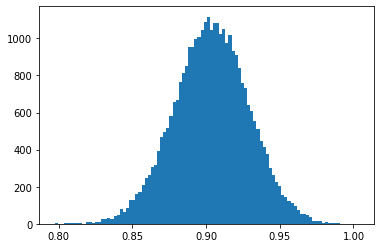

In [90]:
def experiment(pf, size=32768):
    """The actual experiment, shows the `size` amount of returns for provided portfolio
    
    Each default is sample from Bernoulli distribution.
    Return of the bond is sample from default * (yield + 1)
    Return of the `pf` if weighted sum of the returns of each bond.
    
    Calculating return `size` amount of times we can estimate `pmf` of return random var
    
    """
    rets = pf['yields'] * pf['w']
    
    defaults = stats.bernoulli.rvs(pf['p'], size=(size, len(rets)))
    ret = (1 - defaults) @ rets
    
    return ret

plt.hist(experiment(df), bins='auto');

In [92]:
# looks like normal, but skewed, beta distribuiton might be a good fit
data = experiment(df, size=65536)
mean = np.mean(data)
std = np.std(data)
norm_data = (data - mean)/std

alpha = .005
_, p = stats.normaltest(norm_data)
p, p > alpha

(3.00337961966581e-17, False)

In [93]:
from concurrent.futures import ProcessPoolExecutor

def simple_run_tests(
    portfolio_size,
    tries,
    experiment_size,
    alpha,
):
    """Genrerate random portfolios of specified sizes and test agains different dists"""
    tot = 0
    norm = 0
    beta = 0
    for t in range(tries):
        pf = mk_portfolio(grp_size=portfolio_size//7)
        rets = experiment(pf, size=experiment_size)
        mean = np.mean(rets)
        std  = np.std(rets)
        
        beta_params = stats.beta.fit(rets)
        ks_res = stats.kstest(rets, 'beta', beta_params)
        _, p = stats.normaltest(rets)
        tot += 1
        if p > alpha:
            norm += 1
        if ks_res.pvalue > alpha:
            beta += 1
            
    r = {
        'norm': norm/tot,
        'beta': beta/tot,
    }
    print(f'{portfolio_size}: {r}')
    return r
    


In [94]:
%%time
portfolio_sizes = [7, 21, 56, 70, 84, 98, 140, 280, 700]
res = {}
with ProcessPoolExecutor(max_workers=8) as executor:
    futures = []
    for s in portfolio_sizes:
        futures.append(
            executor.submit(
                simple_run_tests,
                portfolio_size = s,
                tries = 512,
                experiment_size = 32768,
                alpha = .005,           
            )
       )
    res = {
        s: r.result()
        for s, r in zip(portfolio_sizes, futures)
    }

res

/home/cvb/.cache/pypoetry/virtualenvs/rnd-stuff-DBXssIu6-py3.8/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/cvb/.cache/pypoetry/virtualenvs/rnd-stuff-DBXssIu6-py3.8/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/cvb/.cache/pypoetry/virtualenvs/rnd-stuff-DBXssIu6-py3.8/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/cvb/.cache/pypoetry/virtualenvs/rnd-stuff-DBXssIu6-py3.8/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten

21: {'norm': 0.0, 'beta': 0.0}
56: {'norm': 0.0, 'beta': 0.689453125}
70: {'norm': 0.0, 'beta': 0.990234375}
98: {'norm': 0.0, 'beta': 1.0}
84: {'norm': 0.0, 'beta': 1.0}
140: {'norm': 0.005859375, 'beta': 1.0}
7: {'norm': 0.0, 'beta': 0.0}
280: {'norm': 0.015625, 'beta': 1.0}
700: {'norm': 0.18359375, 'beta': 1.0}
CPU times: user 31.7 ms, sys: 60.1 ms, total: 91.8 ms
Wall time: 18min 48s


{7: {'norm': 0.0, 'beta': 0.0},
 21: {'norm': 0.0, 'beta': 0.0},
 56: {'norm': 0.0, 'beta': 0.689453125},
 70: {'norm': 0.0, 'beta': 0.990234375},
 84: {'norm': 0.0, 'beta': 1.0},
 98: {'norm': 0.0, 'beta': 1.0},
 140: {'norm': 0.005859375, 'beta': 1.0},
 280: {'norm': 0.015625, 'beta': 1.0},
 700: {'norm': 0.18359375, 'beta': 1.0}}

looks like it's moving toward normal, but slowly, but it might be beta

In [96]:
%%time
portfolio_sizes = [70, 77, 84]
res = {}
with ProcessPoolExecutor(max_workers=8) as executor:
    futures = []
    for s in portfolio_sizes:
        futures.append(
            executor.submit(
                simple_run_tests,
                portfolio_size = s,
                tries = 512,
                experiment_size = 8192, #32768,
                alpha = .005,           
            )
       )
    res = {
        s: r.result()
        for s, r in zip(portfolio_sizes, futures)
    }

res

/home/cvb/.cache/pypoetry/virtualenvs/rnd-stuff-DBXssIu6-py3.8/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/cvb/.cache/pypoetry/virtualenvs/rnd-stuff-DBXssIu6-py3.8/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/cvb/.cache/pypoetry/virtualenvs/rnd-stuff-DBXssIu6-py3.8/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/cvb/.cache/pypoetry/virtualenvs/rnd-stuff-DBXssIu6-py3.8/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured 

70: {'norm': 0.046875, 'beta': 1.0}
84: {'norm': 0.048828125, 'beta': 1.0}
77: {'norm': 0.02734375, 'beta': 1.0}
CPU times: user 9.65 ms, sys: 41.4 ms, total: 51 ms
Wall time: 2min 18s


{70: {'norm': 0.046875, 'beta': 1.0},
 77: {'norm': 0.02734375, 'beta': 1.0},
 84: {'norm': 0.048828125, 'beta': 1.0}}

In [97]:
data = experiment(df, size=65536)
print(np.mean(data), np.std(data), min(data), max(data))
mu, s = stats.norm.fit(data)
mu, s
a, b, loc, scale = stats.beta.fit(data)
a, b, loc, scale


0.9036920105036286 0.02544272663388111 0.8006460386191909 0.9943665167318809


(385.19770444384756,
 123.31508230717711,
 -0.11132809186882212,
 1.3399630872058403)

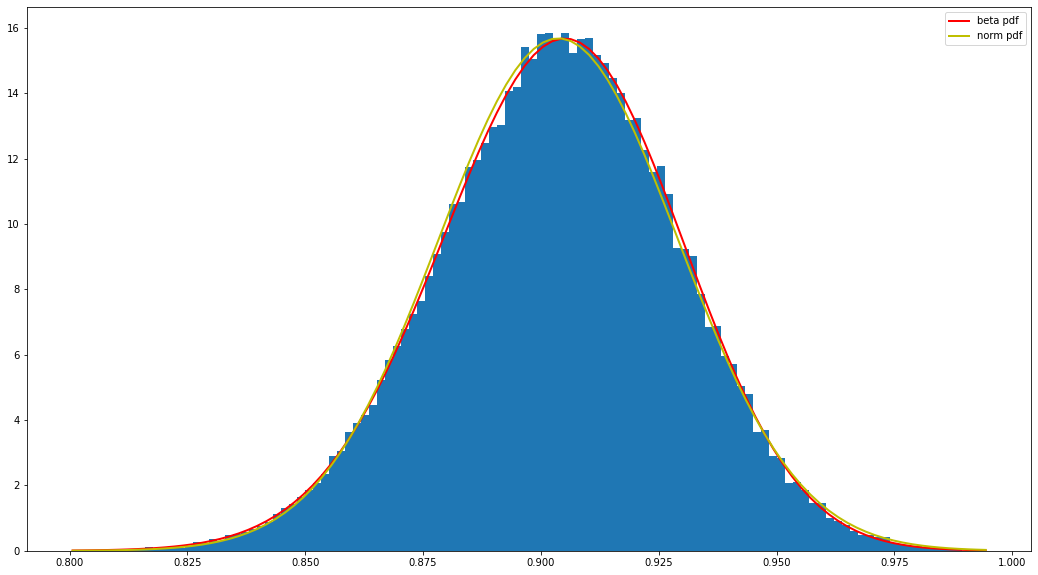

In [98]:
# normal and beta pdfs agains actual histogram
x = np.linspace(min(data), max(data), 100)
plt.figure(figsize=(18, 10))
plt.plot(x, stats.beta.pdf(x, a, b, loc, scale), 'r-', lw=2, alpha=1, label='beta pdf')
plt.plot(x, stats.norm.pdf(x, mu, s), 'y-', lw=2, alpha=1, label='norm pdf')
plt.hist(data, bins='auto', density=True);
plt.legend()

In [102]:
beta = stats.beta.freeze(a, b, loc, scale)

In [103]:
beta.mean(), np.mean(data)

(0.9036920190883794, 0.9036920105036286)

In [104]:
beta.std(), np.std(data)

(0.025442709355593403, 0.02544272663388111)

In [105]:
(data < (np.mean(data) - np.std(data))).sum() / len(data)

0.1588134765625

In [106]:
beta.cdf(beta.mean() - beta.std()) 

0.15877917481893394

the actual probabilities are quite close

# MPT

In [107]:
size = 1024
rets  = []
risks = []
for i in range(size):
    pf = mk_portfolio(grp_size=105)
    exp = experiment(pf, size=8192)
    mean = np.mean(exp)
    std  = np.std(exp)
 
    rets.append(mean)
    risks.append(std)
    

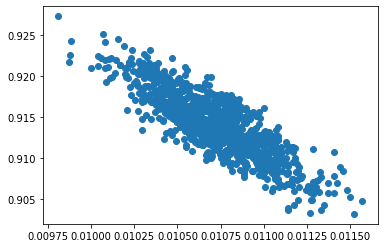

In [108]:
plt.scatter(risks, rets)

In [109]:
# and with real data
pf = pd.read_csv("../out.csv")
pf['yields'] = pf['yields'] + 1


In [110]:
size = 1024
rets  = []
risks = []
meds = []
for i in range(size):
    rnds = np.random.rand(len(pf))
    pf['w'] = rnds/sum(rnds)
    
    exp = experiment(pf, size=8192)
    mean = np.mean(exp)
    std  = np.std(exp)
    med = np.median(exp)
 
    rets.append(mean)
    risks.append(std)
    meds.append(med)
    
    rnds = np.random.rand(len(df))
    df['w'] = rnds/sum(rnds)

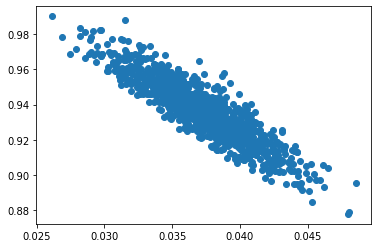

In [111]:
plt.scatter(risks, rets)

This plots doesn't show all possible portfolios beacause weights are random uniform maybe

In [112]:
pf_size = len(pf['isins'])
def risk_fn(ws):
    pf['w'] = ws
    exp = experiment(pf, size=8192)
    
    return np.std(exp)

bounds = [(0, 1)] * pf_size
init_w = [1/pf_size] * pf_size
cons = [{'type': 'eq', 'fun': lambda w: sum(w)-1}]

In [113]:
minimize(risk_fn, init_w, constraints=cons, bounds=bounds)

     fun: 0.032317131731969234
     jac: array([ 12113.57086308,  -2051.08141554,    487.33763594,  18040.99793588,
       -23807.32677454,   2406.70446284,  13887.26136218, -16634.77401864,
        20634.59440945, -19244.2528688 ,   2824.72020882,   6945.22903219,
       -21158.26367209, -17756.95323189,  22178.4863283 , -15207.95086934,
        17641.15974799,  11127.14919018,  -3698.11782584,  31434.0569813 ,
         9708.71666681,   1583.15776288, -10441.31900089,  20718.37329341,
       -15339.81838865, -11546.11931428,  -1624.93220305, -17493.93150987,
        13574.63705861, -22715.53020793, -20412.803649  , -16076.4138367 ,
         2108.45626065, -28046.6174179 ,  -1586.37210059, -26738.75762531,
       -10929.28424379,  -7085.98651797, -17849.74412635,   2233.96732196,
       -18759.1485286 ,  -1779.45440912, -20217.0465059 ,  -9261.89488629,
       -10161.3042941 ,   5443.70328669,   3752.71717379,  -8083.41730801,
         1391.50462135,   6693.12793928,   2432.47307987,  

And it's not minimizing, maybe using real distribution function (built as the weighte sum of Bernoulli) could help